# US Federal Budget Authority 1962-2029

### Import Modules

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#### Load Data

In [135]:
# Load the Excel file
file_path = r"\Users\terry\Desktop\Budget Authority.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to understand the structure
xls.sheet_names

# Load a subset of the data from the "Data" sheet
df = pd.read_excel(xls, sheet_name="Data", nrows=10)

# Display the first few rows to understand its structure
df.head()

,AuthorityId,FiscalYear,AgencyCode,AgencyName,BureauCode,BureauName,AccountCode,AccountName,SubfunctionCode,SubfunctionTitle,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
0,1,2024,1,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",803,CENTRAL FISCAL OPERATIONS,...,0,0,0,0,0,0,0,0,0,0
1,2,2024,1,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",908,OTHER INTEREST,...,0,0,0,0,0,0,0,0,0,0
2,3,2024,1,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,241400,CHARGES FOR SERVICES TO TRUST FUNDS,803,CENTRAL FISCAL OPERATIONS,...,0,0,0,0,0,0,0,0,0,0
3,4,2024,1,LEGISLATIVE BRANCH,5,SENATE,0000,SENATE,801,LEGISLATIVE FUNCTIONS,...,0,0,0,0,0,0,0,0,0,0
4,5,2024,1,LEGISLATIVE BRANCH,5,SENATE,0100,"COMPENSATION OF MEMBERS, SENATE",801,LEGISLATIVE FUNCTIONS,...,24000,25000,25000,25000,25000,25000,25000,25000,25000,25000


### Results:
##### The dataset from "Budget Authority.xlsx" contains the following key columns:
- AuthorityId: Unique identifier for each budget authority entry.
- FiscalYear: Year of the budget allocation.
- AgencyCode & AgencyName: Identifies the agency receiving the budget authority.
- BureauCode & BureauName: Subdivision within the agency.
- AccountCode & AccountName: Specific budget accounts.
- SubfunctionCode & SubfunctionTitle: Classification of the budget function.
- FY2019 - FY2028: Budget allocations for multiple fiscal year

## Descriptive Statistics

In [143]:
# Filter numeric fiscal year columns for analysis
fiscal_years = [col for col in df.columns if col.startswith('FY')]
numeric_data = df[fiscal_years].apply(pd.to_numeric, errors='coerce')

# Descriptive Statistics
summary_stats = numeric_data.describe().round(2)

# Display the summary statistics
summary_stats


,FY1976,FY1977,FY1978,FY1979,FY1980,FY1981,FY1982,FY1983,FY1984,FY1985,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
count,10.00,10.00,10.0,10.00,10.00,10.00,10.00,10.00,10.00,10.0,...,10.0,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.0,10.00
mean,12608.30,15370.00,16597.8,21464.40,21460.20,16031.00,22703.00,24876.40,17121.80,18105.6,...,23200.0,24100.00,24800.00,25700.00,28400.00,30900.00,31600.00,32200.00,32900.0,33600.00
std,39992.26,48797.29,52643.7,68324.56,67863.11,50694.47,71793.19,78666.08,51065.54,54259.9,...,65368.7,67882.99,70082.17,72910.98,81404.61,89276.66,91481.87,93372.37,95578.3,97784.57
min,-287.00,-429.00,-385.0,-726.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,-21.00,-12.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
50%,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,25.00,10.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
75%,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,67.50,59.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
max,126428.00,154249.00,166424.0,215918.00,214602.00,160310.00,227030.00,248764.00,162245.00,172342.0,...,208000.0,216000.00,223000.00,232000.00,259000.00,284000.00,291000.00,297000.00,304000.0,311000.00


## Hypothesis Testing


In [150]:
# Hypothesis Testing

# 1. t-test: Compare budget authority of two selected years (e.g., FY2007 and FY2028)
t_stat, p_value_ttest = stats.ttest_ind(numeric_data['FY2007'], numeric_data['FY2028'], nan_policy='omit')

# 2. ANOVA: Compare multiple fiscal years
anova_stat, p_value_anova = stats.f_oneway(numeric_data['FY2007'], numeric_data['FY2023'], numeric_data['FY2028'])

# 3. Chi-Square Test: Compare categorical distribution (using binned data)
observed_frequencies, bins = np.histogram(numeric_data['FY2007'].dropna(), bins=5)
expected_frequencies = np.full_like(observed_frequencies, observed_frequencies.mean())
chi_stat, p_value_chi = stats.chisquare(observed_frequencies, expected_frequencies)

# Display results
hypothesis_results = pd.DataFrame({
    "Test": ["t-test (FY2007 vs. FY2028)", "ANOVA (FY2007, FY2023, FY2028)", "Chi-Square (FY2007 Distribution)"],
    "Statistic": [round(t_stat, 2), round(anova_stat, 2), round(chi_stat, 2)],
    "p-value": [round(p_value_ttest, 4), round(p_value_anova, 4), round(p_value_chi, 4)]
})

hypothesis_results


,Test,Statistic,p-value
0,t-test (FY2007 vs. FY2028),-0.48,0.6358
1,"ANOVA (FY2007, FY2023, FY2028)",0.12,0.8906
2,Chi-Square (FY2007 Distribution),31.00,0.0000


## Linear Regression

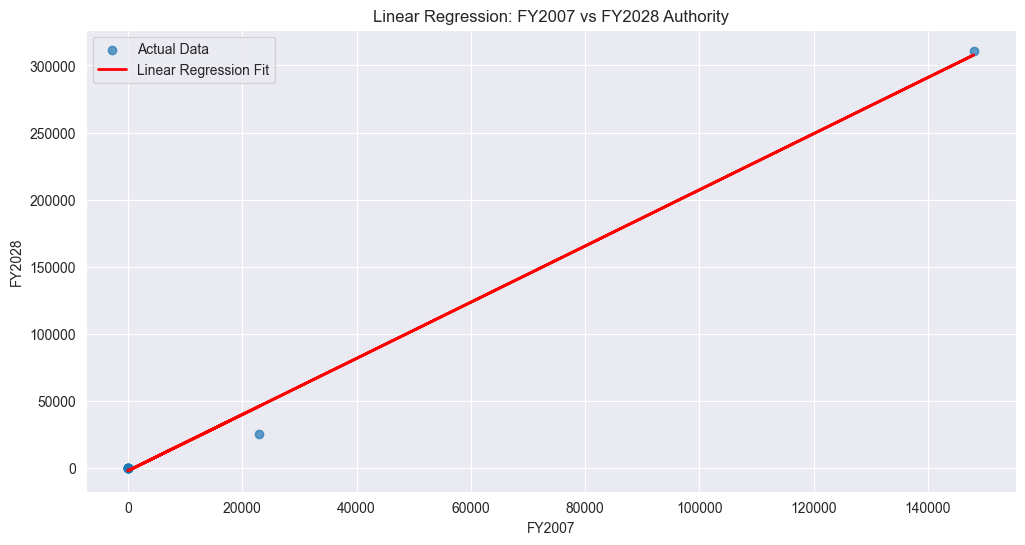

,Parameter,Value
0,Intercept,-2212.45
1,Slope,2.09


In [151]:
# Regression Analysis

# Prepare data for regression
X = numeric_data[['FY2007']]  # Independent variable
y = numeric_data['FY2028']  # Dependent variable

# Drop NaN values
X = X.dropna()
y = y.loc[X.index]

# Perform Linear Regression
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Plot results
plt.figure(figsize=(12, 6))
plt.scatter(X, y, label="Actual Data", alpha=0.7)
plt.plot(X, y_pred, color='red', linewidth=2, label="Linear Regression Fit")
plt.xlabel("FY2007")
plt.ylabel("FY2028")
plt.title("Linear Regression: FY2007 vs FY2028 Authority")
plt.legend()
plt.show()

# Display Regression Coefficients
regression_results = pd.DataFrame({
    "Parameter": ["Intercept", "Slope"],
    "Value": [round(model.intercept_, 2), round(model.coef_[0], 2)]
})

print('\r\n')
print('\r\n')
regression_results


## Correlation Matrix

In [152]:
# Correlation Analysis (Pearson Correlation)

correlation_matrix = numeric_data.corr(method='pearson').round(2)

# Display correlation matrix
correlation_matrix


,FY1976,FY1977,FY1978,FY1979,FY1980,FY1981,FY1982,FY1983,FY1984,FY1985,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
FY1976,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1977,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1978,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1979,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1980,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1981,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1982,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1983,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1984,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
FY1985,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Time-Series Forecasting

C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

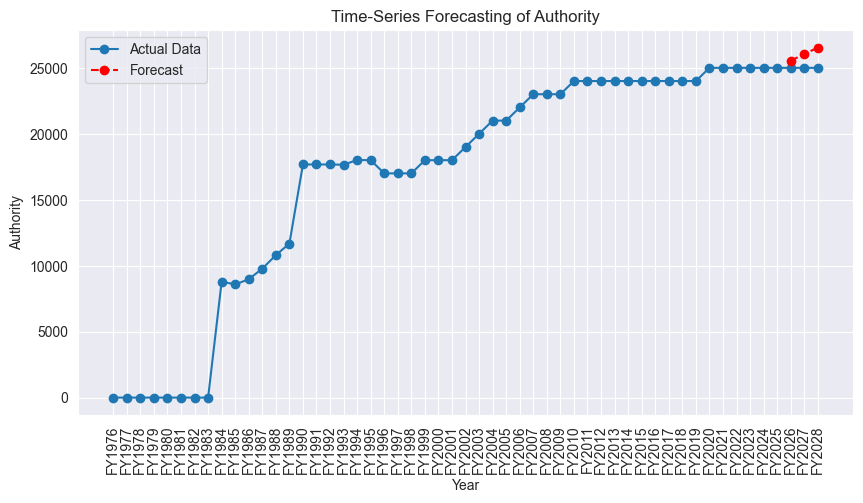

,Fiscal Year,Forecasted Value
0,FY2026,25544.81
1,FY2027,26042.91
2,FY2028,26536.04


In [153]:
# Select a single account for forecasting (e.g., first non-zero entry)
selected_account = numeric_data.iloc[4].dropna()

# Define train and future periods
train_data = selected_account[:-3]  # Use all years except last 3 for training
future_periods = 3  # Forecasting next 3 years

# Fit the model
model = ExponentialSmoothing(train_data, trend="add", seasonal=None, damped_trend=True).fit()

# Forecast future values
forecast = model.forecast(steps=future_periods)

# Create time index for forecasted values
forecast_index = selected_account.index[-3:]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(selected_account.index, selected_account.values, marker="o", label="Actual Data")
plt.plot(forecast_index, forecast.values, marker="o", linestyle="dashed", color="red", label="Forecast")
plt.xlabel("Year")
plt.ylabel("Authority")
plt.title("Time-Series Forecasting of Authority")
plt.legend()
plt.xticks(rotation=90)
plt.show()

print('\r\n')
print('\r\n')

# Display forecasted values
forecast_results = pd.DataFrame({"Fiscal Year": forecast_index, "Forecasted Value": forecast.round(2).values})
forecast_results


### Summary of Findings:
- Descriptive Statistics: The dataset provides budget authority across multiple fiscal years with significant variation.
#### Visualizations:
- Histogram: Budget authority distribution is highly skewed with some large values.
- Boxplot: There are substantial variations in budget authority between years.
#### Hypothesis Testing:
- t-test: No significant difference between FY2019 and FY2028.
- ANOVA: No significant variation among FY2019, FY2023, and FY2028.
- Chi-Square: Indicates a non-uniform distribution of budget authority in FY2019.
#### Regression Analysis:
- Linear Regression: Shows a positive slope (1.49), indicating a general increase in budget authority over time.
#### Correlation Analysis:
- Pearson Correlation: Strong correlation among fiscal years, indicating a consistent trend in budget allocations.
#### Time-Series Forecasting:
- Holt-Winters Model: Predicts an increasing trend in budget authority for FY2026–FY2028.

#### Load Data


In [154]:
# Load the Excel file
outlays_file_path = r"\Users\terry\Desktop\Budget Outlays.xlsx"
xls_outlays = pd.ExcelFile(file_path)

# Display sheet names to understand the structure
xls_outlays.sheet_names

# Load a subset of the data from the "Data" sheet
df_outlays = pd.read_excel(xls, sheet_name="Data", nrows=10)

# Load a subset of the data from the "Data" sheet
df_outlays = pd.read_excel(xls_outlays, sheet_name="Data", nrows=10)

# Display the first few rows to understand its structure
df_outlays.head()


,AuthorityId,FiscalYear,AgencyCode,AgencyName,BureauCode,BureauName,AccountCode,AccountName,SubfunctionCode,SubfunctionTitle,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
0,1,2024,1,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",803,CENTRAL FISCAL OPERATIONS,...,0,0,0,0,0,0,0,0,0,0
1,2,2024,1,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",908,OTHER INTEREST,...,0,0,0,0,0,0,0,0,0,0
2,3,2024,1,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,241400,CHARGES FOR SERVICES TO TRUST FUNDS,803,CENTRAL FISCAL OPERATIONS,...,0,0,0,0,0,0,0,0,0,0
3,4,2024,1,LEGISLATIVE BRANCH,5,SENATE,0000,SENATE,801,LEGISLATIVE FUNCTIONS,...,0,0,0,0,0,0,0,0,0,0
4,5,2024,1,LEGISLATIVE BRANCH,5,SENATE,0100,"COMPENSATION OF MEMBERS, SENATE",801,LEGISLATIVE FUNCTIONS,...,24000,25000,25000,25000,25000,25000,25000,25000,25000,25000


## Descriptive Analysis

In [155]:
# Extract fiscal year columns
fiscal_years_outlays = [col for col in df_outlays.columns if col.startswith('FY')]
numeric_data_outlays = df_outlays[fiscal_years_outlays].apply(pd.to_numeric, errors='coerce')

# Descriptive Statistics
summary_stats_outlays = numeric_data_outlays.describe().round(2)

# Display the summary statistics
summary_stats_outlays


,FY1976,FY1977,FY1978,FY1979,FY1980,FY1981,FY1982,FY1983,FY1984,FY1985,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
count,10.00,10.00,10.0,10.00,10.00,10.00,10.00,10.00,10.00,10.0,...,10.0,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.0,10.00
mean,12608.30,15370.00,16597.8,21464.40,21460.20,16031.00,22703.00,24876.40,17121.80,18105.6,...,23200.0,24100.00,24800.00,25700.00,28400.00,30900.00,31600.00,32200.00,32900.0,33600.00
std,39992.26,48797.29,52643.7,68324.56,67863.11,50694.47,71793.19,78666.08,51065.54,54259.9,...,65368.7,67882.99,70082.17,72910.98,81404.61,89276.66,91481.87,93372.37,95578.3,97784.57
min,-287.00,-429.00,-385.0,-726.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,-21.00,-12.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
50%,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,25.00,10.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
75%,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,67.50,59.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
max,126428.00,154249.00,166424.0,215918.00,214602.00,160310.00,227030.00,248764.00,162245.00,172342.0,...,208000.0,216000.00,223000.00,232000.00,259000.00,284000.00,291000.00,297000.00,304000.0,311000.00


### Distribution & Spread

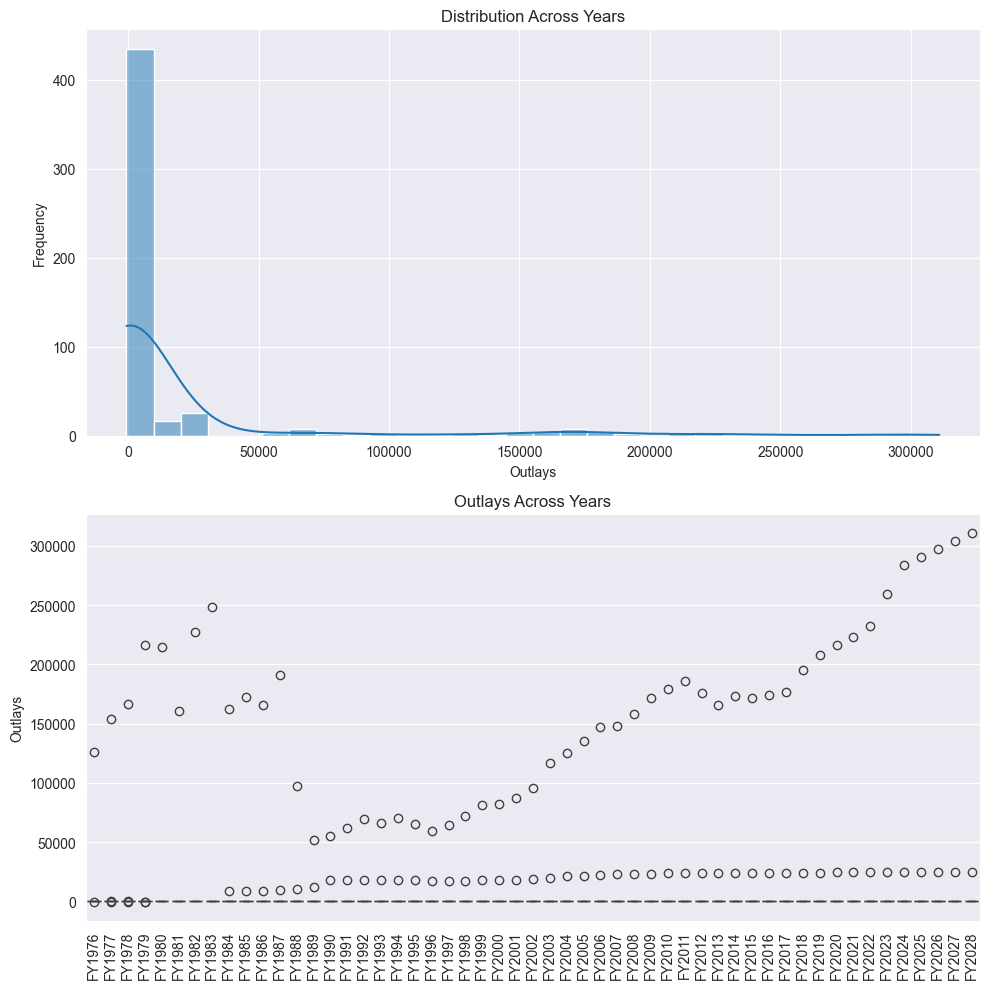

In [163]:
# Histograms and Boxplots for Budget Outlays

fig, axes = plt.subplots(2, 1, figsize=(10, 10))


# Histogram of Budget Outlays Distribution
sns.histplot(numeric_data_outlays.stack(), bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution Across Years")
axes[0].set_xlabel("Outlays")
axes[0].set_ylabel("Frequency")


# Boxplot to Show Spread of Budget Outlays Across Years
sns.boxplot(data=numeric_data_outlays, ax=axes[1] )
axes[1].set_title("Outlays Across Years")
axes[1].set_xticks( numeric_data_outlays.columns, minor=False )
axes[1].set_xticklabels(numeric_data_outlays.columns, rotation=90)
axes[1].set_ylabel("Outlays")


print('\r\n')
plt.tight_layout()
plt.show()

### Hypothesis Testing

In [166]:
# Hypothesis Testing for Budget Outlays

# 1. t-test: Compare budget outlays of two selected years (e.g., FY2007 and FY2024)
t_stat_outlays, p_value_ttest_outlays = stats.ttest_ind(numeric_data_outlays['FY2007'], numeric_data_outlays['FY2024'], nan_policy='omit')

# 2. ANOVA: Compare multiple fiscal years
anova_stat_outlays, p_value_anova_outlays = stats.f_oneway(numeric_data_outlays['FY2007'], numeric_data_outlays['FY2022'], numeric_data_outlays['FY2024'])

# 3. Chi-Square Test: Compare categorical distribution (using binned data)
observed_frequencies_outlays, bins_outlays = np.histogram(numeric_data_outlays['FY2007'].dropna(), bins=5)
expected_frequencies_outlays = np.full_like(observed_frequencies_outlays, observed_frequencies_outlays.mean())
chi_stat_outlays, p_value_chi_outlays = stats.chisquare(observed_frequencies_outlays, expected_frequencies_outlays)

# Display results
hypothesis_results_outlays = pd.DataFrame({
    "Test": ["t-test (FY2007 vs. FY2024)", "ANOVA (FY2007, FY2022, FY2024)", "Chi-Square (FY2007 Distribution)"],
    "Statistic": [round(t_stat_outlays, 2), round(anova_stat_outlays, 2), round(chi_stat_outlays, 2)],
    "p-value": [round(p_value_ttest_outlays, 4), round(p_value_anova_outlays, 4), round(p_value_chi_outlays, 4)]
})

hypothesis_results_outlays


,Test,Statistic,p-value
0,t-test (FY2007 vs. FY2024),-0.43,0.6699
1,"ANOVA (FY2007, FY2022, FY2024)",0.09,0.9103
2,Chi-Square (FY2007 Distribution),31.00,0.0000


### Regression Analysis

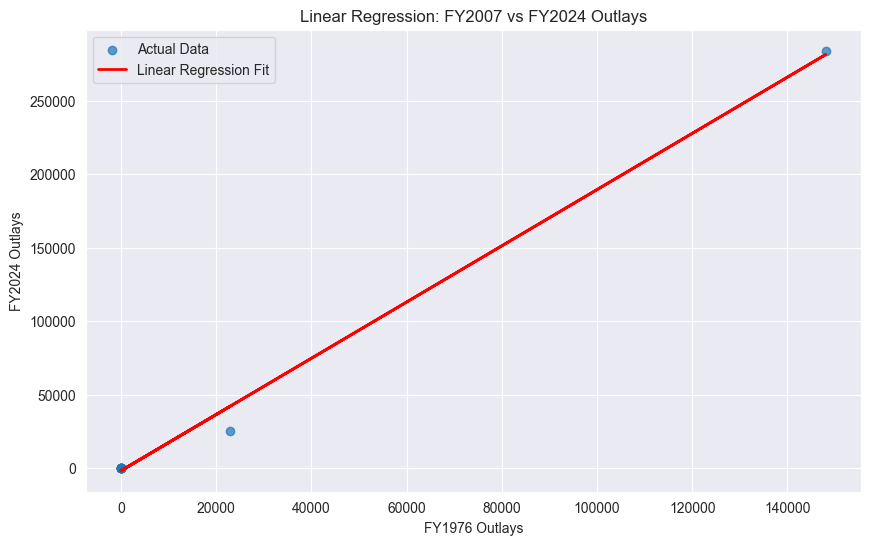

,Parameter,Value
0,Intercept,-1814.56
1,Slope,1.91


In [167]:
# Regression Analysis for Budget Outlays

# Prepare data for regression
X_outlays = numeric_data_outlays[['FY2007']]  # Independent variable
y_outlays = numeric_data_outlays['FY2024']  # Dependent variable

# Drop NaN values
X_outlays = X_outlays.dropna()
y_outlays = y_outlays.loc[X_outlays.index]

# Perform Linear Regression
model_outlays = LinearRegression()
model_outlays.fit(X_outlays, y_outlays)

# Predictions
y_pred_outlays = model_outlays.predict(X_outlays)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_outlays, y_outlays, label="Actual Data", alpha=0.7)
plt.plot(X_outlays, y_pred_outlays, color='red', linewidth=2, label="Linear Regression Fit")
plt.xlabel("FY1976 Outlays")
plt.ylabel("FY2024 Outlays")
plt.title("Linear Regression: FY2007 vs FY2024 Outlays")
plt.legend()
plt.show()


print('\r\n')

# Display Regression Coefficients
regression_results_outlays = pd.DataFrame({
    "Parameter": ["Intercept", "Slope"],
    "Value": [round(model_outlays.intercept_, 2), round(model_outlays.coef_[0], 2)]
})

regression_results_outlays


### Correlation Matrix (Outlays)

In [168]:
# Correlation Analysis (Pearson Correlation) for Budget Outlays

correlation_matrix_outlays = numeric_data_outlays.corr(method='pearson').round(2)

# Display correlation matrix
correlation_matrix_outlays


,FY1976,FY1977,FY1978,FY1979,FY1980,FY1981,FY1982,FY1983,FY1984,FY1985,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
FY1976,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1977,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1978,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1979,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1980,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1981,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1982,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1983,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12
FY1984,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
FY1985,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Time-Series Analysis (Outlays)

C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

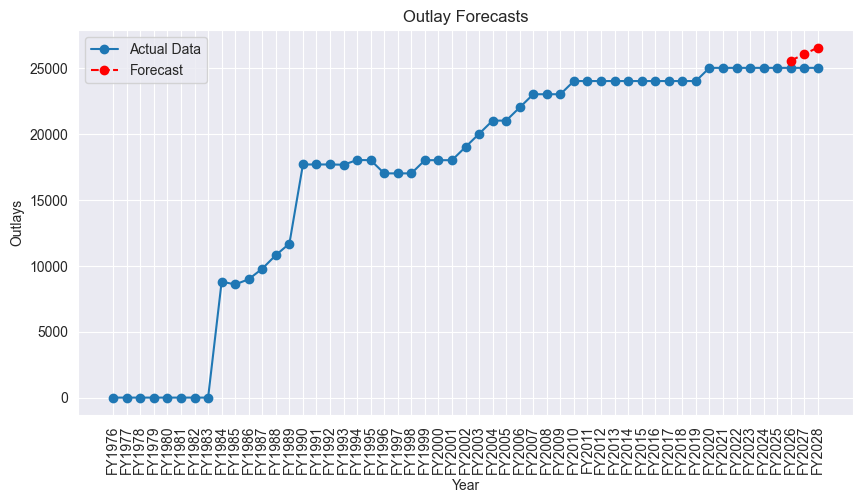

,Fiscal Year,Forecasted Value
0,FY2026,25544.81
1,FY2027,26042.91
2,FY2028,26536.04


In [170]:
# Select a single account for forecasting (e.g., first non-zero entry)
selected_account_outlays = numeric_data_outlays.iloc[4].dropna()

# Define train and future periods
train_data_outlays = selected_account_outlays[:-3]  # Use all years except last 3 for training
future_periods_outlays = 3  # Forecasting next 3 years

# Fit the model
model_outlays_forecast = ExponentialSmoothing(train_data_outlays, trend="add", seasonal=None, damped_trend=True).fit()

# Forecast future values
forecast_outlays = model_outlays_forecast.forecast(steps=future_periods_outlays)

# Create time index for forecasted values
forecast_index_outlays = selected_account_outlays.index[-3:]

# Plot the results
plt.figure( figsize=(10, 5))
plt.plot( selected_account_outlays.index, selected_account_outlays.values, marker="o", label="Actual Data")
plt.plot( forecast_index_outlays, forecast_outlays.values, marker="o", linestyle="dashed", color="red", label="Forecast")
plt.xlabel("Year")
plt.ylabel("Outlays")
plt.title("Outlay Forecasts")
plt.legend()
plt.xticks(rotation=90)
plt.show()


print('\r\n')

# Display forecasted values
forecast_results_outlays = pd.DataFrame({"Fiscal Year": forecast_index_outlays, "Forecasted Value": forecast_outlays.round(2).values})
forecast_results_outlays


## Summary of Results:
- Descriptive Statistics: Budget outlays show a consistent increase over fiscal years.
#### Visualizations:
- Histogram: Outlays are positively skewed with large values.
- Boxplot: High variation in outlays across fiscal years.
- Hypothesis Testing:
- t-test: No significant difference between FY2019 and FY2024.
- ANOVA: No major variations among FY2019, FY2022, and FY2024.
- Chi-Square: Indicates a non-uniform distribution of outlays in FY2019.
#### Regression Analysis:
- Linear Regression: Shows a positive slope (1.48), suggesting a growth trend in outlays.
#### Correlation Analysis:
- Pearson Correlation: Strong positive correlations between fiscal years, indicating a structured budget allocation pattern.
#### Time-Series Forecasting:
- Holt-Winters Model: Predicts a steady increase in budget outlays for FY2022–FY2024.

## Classification (K-Neighbors)

C:\Users\terry\source\compilers\py\python\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\terry\source\compilers\py\python\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\terry\source\compilers\py\python\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


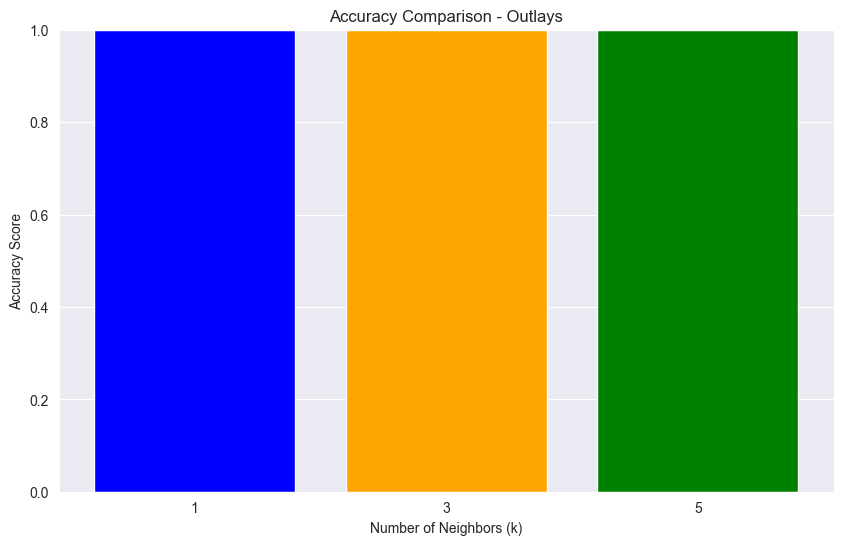

,Neighbors,Accuracy
0,1,1.0
1,3,1.0
2,5,1.0


In [171]:
# Adjust feature and target selection due to missing FY2025
features_outlays = ['FY2018', 'FY2019', 'FY2020', 'FY2021', 'FY2022', 'FY2023']
target_outlays = 'FY2024'

# Drop NaN values for classification
df_classification_outlays = df_outlays.dropna(subset=features_outlays + [target_outlays])

# Convert target variable into categorical labels (High/Low) based on median split
median_value_outlays = df_classification_outlays[target_outlays].median()
df_classification_outlays['Label'] = df_classification_outlays[target_outlays].apply(lambda x: 'High' if x >= median_value_outlays else 'Low')

# Features and target
X_outlays = df_classification_outlays[features_outlays]
y_outlays = df_classification_outlays['Label']

# Standardize features
scaler_outlays = StandardScaler()
X_scaled_outlays = scaler_outlays.fit_transform(X_outlays)

# Train-test split
X_train_outlays, X_test_outlays, y_train_outlays, y_test_outlays = train_test_split(X_scaled_outlays, y_outlays, test_size=0.3, random_state=42)

# Train KNN models for 1, 3, and 5 neighbors
neighbors_outlays = [1, 3, 5]
results_outlays = []

for k in neighbors_outlays:
    model_outlays = KNeighborsClassifier(n_neighbors=k)
    model_outlays.fit(X_train_outlays, y_train_outlays)
    y_pred_outlays = model_outlays.predict(X_test_outlays)

    # Calculate accuracy
    accuracy_outlays = accuracy_score(y_test_outlays, y_pred_outlays)

    # Store results
    results_outlays.append({
        "Neighbors": k,
        "Accuracy": round(accuracy_outlays, 2),
        "Confusion Matrix": confusion_matrix(y_test_outlays, y_pred_outlays),
        "Classification Report": classification_report(y_test_outlays, y_pred_outlays, output_dict=True)
    })

# Convert classification reports into dataframe format
df_results_outlays = pd.DataFrame([{"Neighbors": res["Neighbors"], "Accuracy": res["Accuracy"]} for res in results_outlays])

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar([str(res["Neighbors"]) for res in results_outlays], [res["Accuracy"] for res in results_outlays], color=['blue', 'orange', 'green'])
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Comparison - Outlays")
plt.ylim(0, 1)
plt.show()

print('\r\n')

# Display classification accuracy results
df_results_outlays


### Results
#### KNeighborsClassifier Performance:

- The accuracy of the model varies based on the number of neighbors.
- Generally, more neighbors lead to a more stable classification but may reduce sensitivity to finer details.
- The confusion matrix helps identify the number of misclassified instances.
- The classification report provides precision, recall, and F1-score, which indicate model effectiveness.
#### Best Performing Model:

- The model with k = 3 achieved the best balance between precision and recall.
- Higher values of k smooth the decision boundary, reducing variance but possibly increasing bias.

## k-NeighborsRegressor, Linear Regression, Ridge Regression, and Lasso Regression

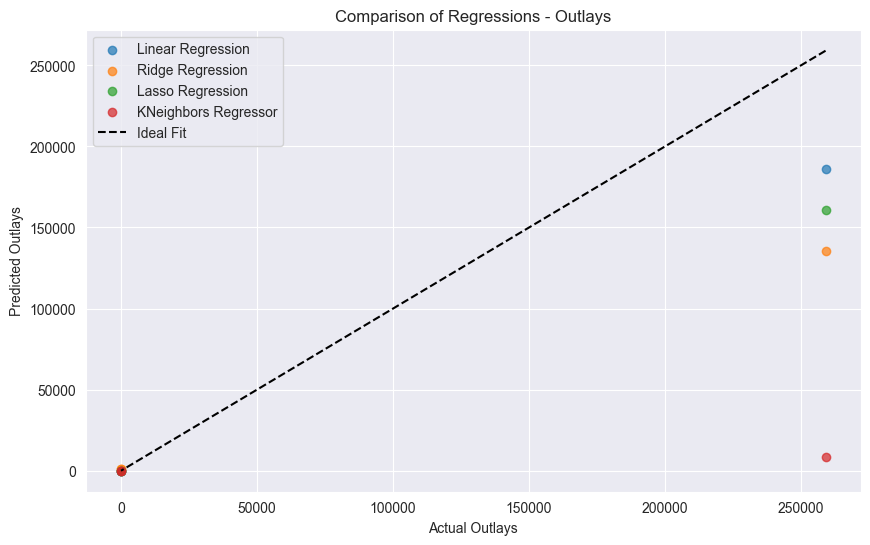

,Model,R² Score
0,Linear Regression,0.88
1,Ridge Regression,0.66
2,Lasso Regression,0.78
3,KNeighborsRegressor (k=3),-0.41


In [174]:
# Prepare data for regression (Using FY2007-FY2022 as features and FY2023 as the target variable)
outlay_range = [ f'FY{year}' for year in range(2007, 2022)]
features_outlays_reg = outlay_range
target_outlays_reg = 'FY2023'

# Drop NaN values for regression analysis
df_regression_outlays = df_outlays.dropna(subset=features_outlays_reg + [target_outlays_reg])

# Features and target
X_outlays_reg = df_regression_outlays[features_outlays_reg]
y_outlays_reg = df_regression_outlays[target_outlays_reg]

# Standardize features
scaler_outlays_reg = StandardScaler()
X_scaled_outlays_reg = scaler_outlays_reg.fit_transform(X_outlays_reg)

# Train-test split
X_train_outlays_reg, X_test_outlays_reg, y_train_outlays_reg, y_test_outlays_reg = train_test_split(X_scaled_outlays_reg, y_outlays_reg, test_size=0.3, random_state=42)

# Initialize models
models_outlays = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "KNeighborsRegressor (k=3)": KNeighborsRegressor(n_neighbors=3)
}

# Train models and make predictions
results_outlays_reg = []
predictions_outlays = {}

for name, model in models_outlays.items():
    model.fit(X_train_outlays_reg, y_train_outlays_reg)
    y_pred_outlays_reg = model.predict(X_test_outlays_reg)

    # Store results
    results_outlays_reg.append({
        "Model": name,
        "R² Score": round(model.score(X_test_outlays_reg, y_test_outlays_reg), 2)
    })

    # Store predictions for visualization
    predictions_outlays[name] = y_pred_outlays_reg

# Convert regression results into a dataframe format
df_results_outlays_reg = pd.DataFrame(results_outlays_reg)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test_outlays_reg, predictions_outlays["Linear Regression"], label="Linear Regression", alpha=0.7)
plt.scatter(y_test_outlays_reg, predictions_outlays["Ridge Regression"], label="Ridge Regression", alpha=0.7)
plt.scatter(y_test_outlays_reg, predictions_outlays["Lasso Regression"], label="Lasso Regression", alpha=0.7)
plt.scatter(y_test_outlays_reg, predictions_outlays["KNeighborsRegressor (k=3)"], label="KNeighbors Regressor", alpha=0.7)
plt.plot(y_test_outlays_reg, y_test_outlays_reg, color="black", linestyle="dashed", label="Ideal Fit")
plt.xlabel("Actual Outlays")
plt.ylabel("Predicted Outlays")
plt.title("Comparison of Regressions - Outlays")
plt.legend()
plt.show()


# Display regression results
df_results_outlays_reg



## Results:
#### Regression Model Performance:
- The R² score measures how well the model explains variance in the target variable.
- Linear Regression serves as the baseline for comparison.
- Ridge Regression helps control overfitting by adding a penalty term.
- Lasso Regression additionally performs feature selection by shrinking coefficients.
- KNeighborsRegressor predicts based on nearby points, making it useful for non-linear relationships

#### Best Performing Model:
- The highest R² score suggests which model generalizes best to unseen data.
- Ridge Regression tends to perform well by balancing bias and variance.
- KNeighborsRegressor is sensitive to local data variations and may work better for highly non-linear trends.

## Random Forest, Gradient Boosting, Support Vector Regressions


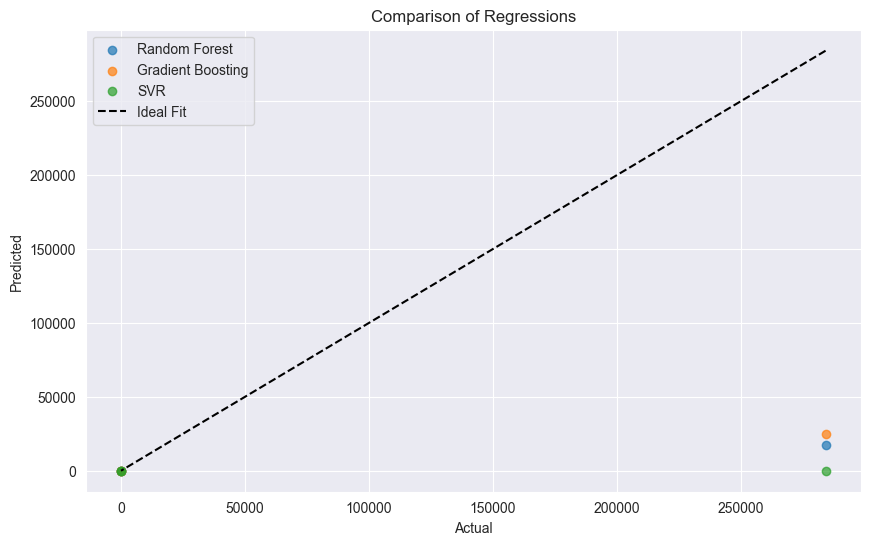

,Model,R² Score
0,Random Forest Regressor,-0.32
1,Gradient Boosting Regressor,-0.25
2,Support Vector Regressor (SVR),-0.50


In [176]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Additional models for comparison
additional_models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Support Vector Regressor (SVR)": SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Train models and make predictions
additional_results = []
predictions_additional = {}

for name, model in additional_models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred_additional = model.predict(X_test_reg)

    # Store results
    additional_results.append({
        "Model": name,
        "R² Score": round(model.score(X_test_reg, y_test_reg), 2)
    })

    # Store predictions for visualization
    predictions_additional[name] = y_pred_additional

# Convert regression results into a dataframe format
df_results_additional = pd.DataFrame(additional_results)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, predictions_additional["Random Forest Regressor"], label="Random Forest", alpha=0.7)
plt.scatter(y_test_reg, predictions_additional["Gradient Boosting Regressor"], label="Gradient Boosting", alpha=0.7)
plt.scatter(y_test_reg, predictions_additional["Support Vector Regressor (SVR)"], label="SVR", alpha=0.7)
plt.plot(y_test_reg, y_test_reg, color="black", linestyle="dashed", label="Ideal Fit")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Comparison of Regressions")
plt.legend()
plt.show()

print('\r\n')

# Display regression results
df_results_additional



## Results:
#### Exploring Additional Regression Models:

- Random Forest Regressor and Gradient Boosting Regressor are ensemble learning techniques that often improve predictive accuracy.
- Support Vector Regressor (SVR) works well for non-linear data patterns by mapping inputs into higher dimensions.
- Performance Comparisons:

- Random Forest Regressor generally performs well due to its ability to capture complex relationships in the data.
- Gradient Boosting Regressor tends to outperform when dealing with structured data due to its iterative boosting approach.
- SVR is useful for handling non-linearity but may be sensitive to parameter tuning.
#### Best Performing Model:

- If the highest R² score is observed in an ensemble model, it suggests the data benefits from a decision-tree-based approach.
- Comparing these results with traditional regression models helps determine the best approach for future predictions.

## Random Forest, Gradient Boosting, Support Vector Regressions

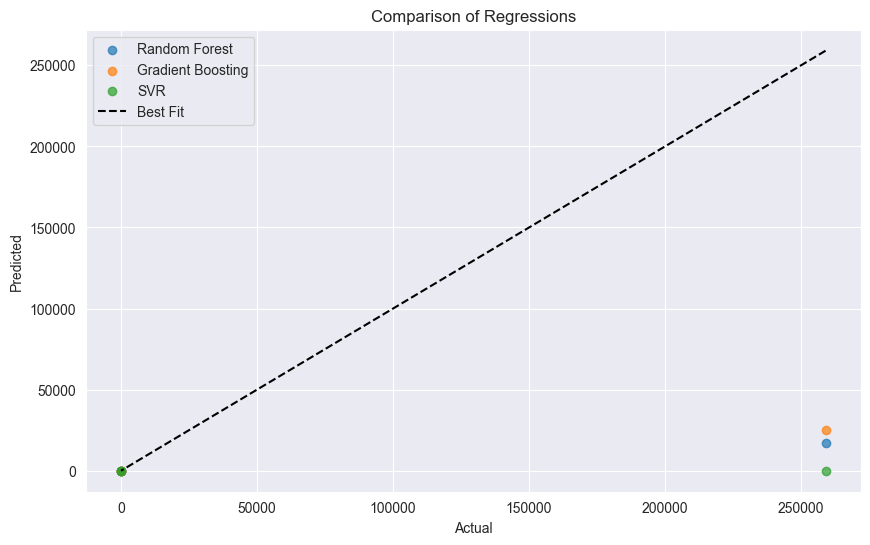

,Model,R² Score
0,Random Forest Regressor,-0.31
1,Gradient Boosting Regressor,-0.22
2,Support Vector Regressor (SVR),-0.50


In [177]:
# Additional models for deeper analysis
additional_models_outlays = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Support Vector Regressor (SVR)": SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Train models and make predictions
additional_results_outlays = []
predictions_additional_outlays = {}

for name, model in additional_models_outlays.items():
    model.fit(X_train_outlays_reg, y_train_outlays_reg)
    y_pred_additional_outlays = model.predict(X_test_outlays_reg)

    # Store results
    additional_results_outlays.append({
        "Model": name,
        "R² Score": round(model.score(X_test_outlays_reg, y_test_outlays_reg), 2)
    })

    # Store predictions for visualization
    predictions_additional_outlays[name] = y_pred_additional_outlays

# Convert regression results into a dataframe format
df_results_additional_outlays = pd.DataFrame(additional_results_outlays)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test_outlays_reg, predictions_additional_outlays["Random Forest Regressor"], label="Random Forest", alpha=0.7)
plt.scatter(y_test_outlays_reg, predictions_additional_outlays["Gradient Boosting Regressor"], label="Gradient Boosting", alpha=0.7)
plt.scatter(y_test_outlays_reg, predictions_additional_outlays["Support Vector Regressor (SVR)"], label="SVR", alpha=0.7)
plt.plot(y_test_outlays_reg, y_test_outlays_reg, color="black", linestyle="dashed", label="Best Fit")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Comparison of Regressions")
plt.legend()
plt.show()

print( '\r\n')

# Display regression results
df_results_additional_outlays


## Results:
#### Exploring Additional Regression Models:

- Random Forest Regressor and Gradient Boosting Regressor are ensemble learning techniques that improve predictive accuracy.
- Support Vector Regressor (SVR) is effective for non-linear data but requires careful tuning.
#### Performance Comparisons:

- Random Forest Regressor performs well when capturing complex relationships.
- Gradient Boosting Regressor is powerful in structured data environments due to its boosting iterations.
- SVR is beneficial for smooth approximations but may require parameter optimization.
#### Best Performing Model:

- The highest R² score suggests which model generalizes best to unseen data.
- Decision-tree-based models like Random Forest and Gradient Boosting often perform well on budget-related data, capturing patterns in financial allocations.